In [1]:
%load_ext autoreload
%autoreload 2

In [71]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from hyperopt import hp, space_eval
from xgboost import plot_importance, plot_tree
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer, SplineTransformer, RobustScaler, MaxAbsScaler, MinMaxScaler, QuantileTransformer

from tree_models import run_ada_boost_classifier, run_random_forest_classifier, run_xgboost_classifier, run_xgboost_classifier_search_cv, run_xgboost_classifier_hyperopt, create_xgboost_classifier
from preprocessing import process_dataset, get_where_all_are_non_null, expand_cabin, expand_name, expand_passenger_id_to_group, impute_missing_values, fill_age_column, fill_missing_categorical_columns

sns.set_theme()

DATASET_PATH = "/Users/dincaus/datasets/spaceship-titanic"

TRAIN_PATH = os.path.join(DATASET_PATH, "train.csv")
TEST_PATH = os.path.join(DATASET_PATH, "test.csv")

In [3]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

In [196]:
all_data = pd.concat([train_df, test_df], axis=0)

all_data[["Deck", "CabinNumber", "Side"]] = expand_cabin(all_data)
all_data["PassengerGroup"] = expand_passenger_id_to_group(all_data)
all_data[["FirstName", "LastName"]] = expand_name(all_data)

all_data = all_data.drop(columns=["Name", "Cabin"])

In [197]:
# fill missing values

# categorical
all_data["HomePlanet"] = fill_missing_categorical_columns(all_data, "HomePlanet")
all_data["Destination"] = fill_missing_categorical_columns(all_data, "Destination")
all_data["Deck"] = fill_missing_categorical_columns(all_data, "Deck")
all_data["Side"] = fill_missing_categorical_columns(all_data, "Side")
all_data["VIP"] = fill_missing_categorical_columns(all_data, "VIP")
all_data["CryoSleep"] = fill_missing_categorical_columns(all_data, "CryoSleep")

# numerical

fill_age_column(all_data)
all_data[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "CabinNumber"]] = impute_missing_values(all_data, ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "CabinNumber"], n_neighbors=5)

In [198]:
BOOL_FEATURES = ["CryoSleep", "VIP"]
CATEGORICAL_FEATURES = ["HomePlanet", "Destination", "Deck", "Side", "PassengerGroup", "CabinNumber"]
NUMERICAL_FEATURES = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

In [199]:
# # convert categorical to labels and bool to int
# categorical_encoders = {
#     cat: LabelEncoder()
#     for cat in CATEGORICAL_FEATURES
# }
#
for cat_col in CATEGORICAL_FEATURES:
    # all_data[cat_col] = categorical_encoders[cat_col].fit_transform(all_data[cat_col])
    # all_data[cat_col] = pd.get_dummies(all_data[cat_col], prefix=cat_col)
    all_data[cat_col] = all_data[cat_col].astype("category")

for bool_cat_col in BOOL_FEATURES:
    all_data[bool_cat_col] = all_data[bool_cat_col].astype(np.int32)

# all_data = pd.get_dummies(all_data, columns=["HomePlanet", "Destination", "Deck", "Side"])

In [200]:
# add artificial columns

all_data["TotalMoneySpent"] = all_data["RoomService"] + all_data["FoodCourt"] + all_data["ShoppingMall"] + all_data["Spa"] + all_data["VRDeck"]

all_data["RatioVR"] = (all_data["VRDeck"] / all_data["TotalMoneySpent"]).fillna(0)
all_data["RatioSpa"] = (all_data["Spa"] / all_data["TotalMoneySpent"]).fillna(0)
all_data["RatioShoppingMall"] = (all_data["ShoppingMall"] / all_data["TotalMoneySpent"]).fillna(0)
all_data["RatioRoomService"] = (all_data["RoomService"] / all_data["TotalMoneySpent"]).fillna(0)
all_data["RatioFoodCourt"] = (all_data["FoodCourt"] / all_data["TotalMoneySpent"]).fillna(0)

last_name_count_mapping = pd.concat([all_data.groupby(by="LastName")["LastName"].count(), pd.Series([1], index=[np.nan])])

all_data["FamilySize"] = all_data["LastName"].apply(lambda x: last_name_count_mapping[x])

In [201]:
train_data_df, test_data_df = all_data.loc[~all_data["Transported"].isna()], all_data.loc[all_data["Transported"].isna()]
train_data_df["Transported"] = train_data_df["Transported"].astype(np.int32)

/var/folders/jy/0x3dtb595998ft_1332l_k780000gn/T/ipykernel_18908/3763130414.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_df["Transported"] = train_data_df["Transported"].astype(np.int32)


In [202]:
total_number_of_features = len(NUMERICAL_FEATURES) + len(CATEGORICAL_FEATURES)

print(f"Total number of features: {total_number_of_features}")
best_feature_selection = [
    'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
    'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
    'Deck', 'CabinNumber', 'Side', 'PassengerGroup',
    'TotalMoneySpent', 'RatioVR', 'RatioSpa',
    'RatioShoppingMall', 'RatioRoomService', 'RatioFoodCourt',
    'FamilySize'
]

print(f"Best selected features: {best_feature_selection}")
print(f"Length of best selected features: {len(best_feature_selection)}")

Total number of features: 12
Best selected features: ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Deck', 'CabinNumber', 'Side', 'PassengerGroup', 'TotalMoneySpent', 'RatioVR', 'RatioSpa', 'RatioShoppingMall', 'RatioRoomService', 'RatioFoodCourt', 'FamilySize']
Length of best selected features: 21


In [206]:
XGBOOST_CLASSIFIER_HYPEROPT_SPACE = {
    "n_estimators": hp.choice("n_estimators", np.arange(50, 500, 50, dtype=np.int32).tolist()),
    "min_child_weight": hp.choice("min_child_weight", np.arange(1, 23, 2, dtype=np.int32).tolist()),
    "max_depth": hp.choice("max_depth", np.arange(3, 23, 2, dtype=np.int32).tolist()),
    "gamma": hp.uniform("gamma", 1.0, 9.0),
    "subsample": hp.uniform("subsample", 0.1, 0.9),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.1, 0.9),
    "reg_alpha": hp.quniform("reg_alpha", 40, 180, 1),
    "reg_lambda": hp.uniform("reg_lambda", 0, 1)
}

best_params_hyperopt = run_xgboost_classifier_hyperopt(
    train_df=train_data_df,
    feature_columns=best_feature_selection,
    search_space_params=XGBOOST_CLASSIFIER_HYPEROPT_SPACE,
    tree_method="auto",
    enable_categorical=True,
    label_columns=["Transported"],
    number_iterations=50,
    number_of_splits=10
)

best_params = space_eval(XGBOOST_CLASSIFIER_HYPEROPT_SPACE, best_params_hyperopt)
print(f"Best parameters: {best_params}")

best_estimator = create_xgboost_classifier(**best_params)

XGBoost Search Space: {'n_estimators': <hyperopt.pyll.base.Apply object at 0x7feee6f11670>, 'min_child_weight': <hyperopt.pyll.base.Apply object at 0x7feee69d70a0>, 'max_depth': <hyperopt.pyll.base.Apply object at 0x7feed7714cd0>, 'gamma': <hyperopt.pyll.base.Apply object at 0x7feed7714d30>, 'subsample': <hyperopt.pyll.base.Apply object at 0x7feed7714760>, 'colsample_bytree': <hyperopt.pyll.base.Apply object at 0x7feed7714670>, 'reg_alpha': <hyperopt.pyll.base.Apply object at 0x7feee76fcc10>, 'reg_lambda': <hyperopt.pyll.base.Apply object at 0x7feee6f11fa0>}
Tree method: auto
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

job exception: Experimental support for categorical data is not implemented for current tree method yet.



  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]


ValueError: Experimental support for categorical data is not implemented for current tree method yet.

Best estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8007506824827594, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=1.3494596892756214, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=11, missing=nan, monotone_constraints=None,
              n_estimators=450, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=61.0,
              reg_lambda=0.3159794025407015, ...)
Using features: ['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'PassengerGroup', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Destinat

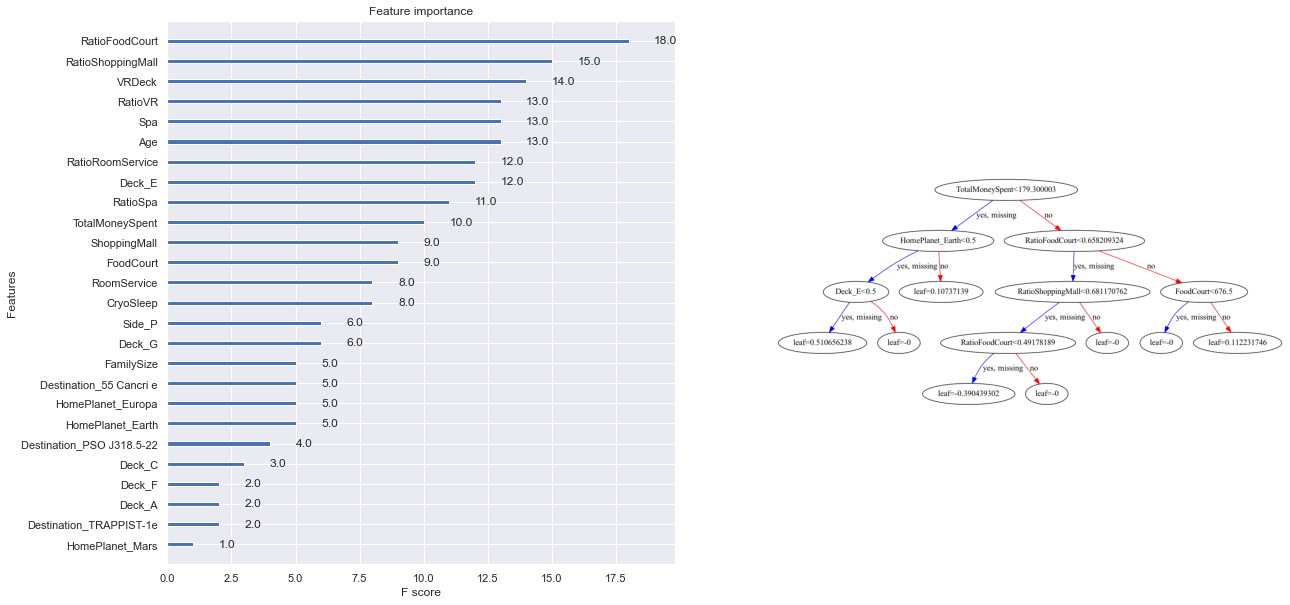

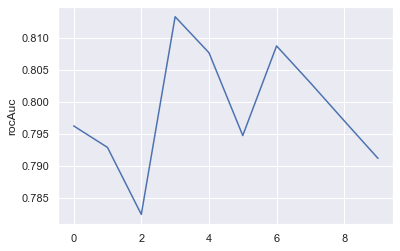

Mean ROC AUC: 0.7987051203483875
Mean Accuracy: 0.7990365461688028
Mean Score: 0.7990365461688028


In [186]:
print(f"Best estimator: {best_estimator}")
print(f"Using features: {best_feature_selection}")

training_results, predictor = run_xgboost_classifier(
    train_df=train_data_df,
    feature_columns=best_feature_selection,
    label_columns=["Transported"],
    number_of_splits=10,
    shuffle=True,
    xgboost_model_predefined=best_estimator
)

_, xg_axs = plt.subplots(1, 2, figsize=(20, 10))

plot_importance(predictor, ax=xg_axs[0])
plot_tree(predictor, ax=xg_axs[1], fontsize=10)
plt.show()

training_df = pd.DataFrame(training_results)

sns.lineplot(data=training_df, x=training_df.index, y="rocAuc")

plt.show()

mean_roc_auc = training_df["rocAuc"].mean()
mean_acc = training_df["accuracy"].mean()
mean_score = training_df["score"].mean()


print(f"Mean ROC AUC: {mean_roc_auc}")
print(f"Mean Accuracy: {mean_acc}")
print(f"Mean Score: {mean_score}")

In [173]:
test_predictions = predictor.predict(test_data_df[best_feature_selection])
test_results = pd.concat([test_data_df["PassengerId"], pd.DataFrame(test_predictions, columns=["Transported"])], axis=1)
test_results["Transported"] = test_results["Transported"].astype(bool)
test_results.to_csv("submission.csv", index=False)

ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:Transported